In [51]:
import tensorflow as tf
import pandas as pd
import numpy as np
import lhapdf
import matplotlib.pyplot as plt
import os


Models_folder = 'SIDIS_Models'
folders_array=os.listdir(Models_folder)
OutputFolder='NN_SIDIS_Plots'
numreplicas_SIDIS=len(folders_array)
#numreplicas_SIDIS=3
print(numreplicas_SIDIS)

pdfset = 'cteq61'
Mp = 0.938

class A0(tf.keras.layers.Layer):
    def __init__(self, kperp2avg=.57, pperp2avg=.12, **kwargs):
        super(A0, self).__init__(name='a0')
        self.m1 = tf.Variable(1., name='m1')
        self.kperp2avg = kperp2avg
        self.pperp2avg = pperp2avg
        self.e = tf.constant(1.)

    def get_config(self):
        config = super().get_config().copy()

        config.update({
            'kperp2avg': self.kperp2avg,
            'pperp2avg': self.pperp2avg
        })
        return config
    

    def call(self, inputs):
        z = inputs[:, 0]
        pht = inputs[:, 1]
        ks2avg = (self.kperp2avg*self.m1**2)/(self.m1**2 + self.kperp2avg) #correct
        topfirst = (z**2 * self.kperp2avg + self.pperp2avg) * ks2avg**2 #correct
        bottomfirst = (z**2 * ks2avg + self.pperp2avg)**2 * self.kperp2avg #correct
        exptop = pht**2 * z**2 * (ks2avg - self.kperp2avg) #correct
        expbottom = (z**2 * ks2avg + self.pperp2avg) * (z**2 * self.kperp2avg + self.pperp2avg) #correct
        last = tf.sqrt(2*self.e) * z * pht / self.m1 #correct
        return (topfirst/bottomfirst) * tf.exp(-exptop/expbottom) * last


class Quotient(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Quotient, self).__init__()

    def call(self, inputs):
        if len(inputs) != 2 or inputs[0].shape[1] != 1:
            raise Exception('must be two tensors of shape (?, 1)')
        return inputs[0]/inputs[1]
    
    
def nnq(model, x, hadronstr):
    if not hadronstr in ['nnu', 'nnd', 'nns', 'nnubar', 'nndbar', 'nnsbar']:
        raise Exception('hadronstr must be one of nnu, nnd, nns, nnubar, nndbar, nnsbar')
    mod_out = tf.keras.backend.function(model.get_layer(hadronstr).input,
                                       model.get_layer(hadronstr).output)
    return mod_out(x)

def pdf_vals(flavor, x, QQ):
    pdfData = lhapdf.mkPDF(pdfset)
    return np.array([pdfData.xfxQ2(flavor, ax, qq) for ax, qq in zip(x, QQ)])

def h(model, kperp):
    m1 = model.get_layer('a0').m1.numpy()
    e = model.get_layer('a0').e.numpy()
    return np.sqrt(2*e) * (kperp/m1) * np.exp(-kperp**2/m1**2)

def fqp(x, QQ, kperp2avg, kperp, flavor):
    fq = pdf_vals(flavor, x, QQ)
    return fq*(1/(np.pi*kperp2avg))*np.exp(-kperp**2/kperp2avg)


def xSivFunction(model, x, QQ, kperp2avg, flavor, kperp):
    refDict = {-3: 'nnsbar',
               -2: 'nnubar',
               -1: 'nndbar',
               1: 'nnd',
               2: 'nnu',
               3: 'nns'}
    nnqval = nnq(model, np.array([x]), refDict[flavor])
    #nnqval = nnq(model , np.array([x]), refDict[flavor])[:,0]
    hval = h(model, kperp)
    fqpval = fqp([x], [QQ], kperp2avg, kperp, flavor)
    return ((2*nnqval*hval*fqpval)[0, :])


def kval(kx,ky):
    return np.sqrt(kx**2 + ky**2)


def density_func(model, x, QQ, kperp2avg, flavor, kxx, kyy):
    kTval = kval(kxx,kyy)
    return fqp(x, QQ, kperp2avg, kTval, flavor) - (kxx/Mp)*xSivFunction(model, x, QQ, kperp2avg, flavor, kTval)


SIDISmodelsArray = []
for i in range(numreplicas_SIDIS):
    #print(str(folders_array[i]))
    testmodel = tf.keras.models.load_model(str(Models_folder)+'/' + str(folders_array[i]),custom_objects={'A0': A0, 'Quotient': Quotient})
    SIDISmodelsArray.append(testmodel)
    
SIDISmodelsArray = np.array(SIDISmodelsArray)

3


In [56]:
kxv = np.array(np.linspace(-1,1,100))
kyv = np.array(np.linspace(-1,1,100))
kTv = kval(kxv,kyv)


def ThreeD_data_FromReplicas(numReplicas, x, QQ, kperp2avg, kx, ky):
    tempfu = []
    tempfd = []
    tempfs = []
    tempfubar = []
    tempfdbar = []
    tempfsbar = []
    for i in range(numReplicas):
        tt = SIDISmodelsArray[i]
        tempfu.append(list(density_func(tt, [x], [QQ], kperp2avg, 2, kx, ky)))
        tempfd.append(list(density_func(tt, [x], [QQ], kperp2avg, 1, kx, ky)))
        tempfs.append(list(density_func(tt, [x], [QQ], kperp2avg, 3, kx, ky)))
        tempfubar.append(list(density_func(tt, [x], [QQ], kperp2avg, -2, kx, ky)))
        tempfdbar.append(list(density_func(tt, [x], [QQ], kperp2avg, -1, kx, ky)))
        tempfsbar.append(list(density_func(tt, [x], [QQ], kperp2avg, -3, kx, ky)))
    return np.array(tempfu),np.array(tempfubar),np.array(tempfd),np.array(tempfdbar),np.array(tempfs),np.array(tempfsbar)

[0.00281178 0.00298006 0.00315402 0.00333351 0.00351832 0.00370823
 0.00390301 0.00410235 0.00430595 0.00451344 0.00472446 0.00493857
 0.00515534 0.00537429 0.00559491 0.00581668 0.00603902 0.00626136
 0.00648309 0.00670358 0.0069222  0.00713828 0.00735115 0.00756013
 0.00776454 0.00796369 0.00815688 0.00834343 0.00852267 0.00869391
 0.00885651 0.00900983 0.00915324 0.00928617 0.00940805 0.00951834
 0.00961654 0.0097022  0.0097749  0.00983427 0.00987997 0.00991174
 0.00992935 0.00993262 0.00992145 0.00989578 0.0098556  0.00980099
 0.00973206 0.009649   0.00955205 0.00944152 0.00931775 0.00918118
 0.00903228 0.00887156 0.00869961 0.00851705 0.00832454 0.00812278
 0.00791253 0.00769453 0.0074696  0.00723855 0.00700221 0.00676142
 0.00651703 0.00626989 0.00602084 0.00577071 0.00552033 0.00527048
 0.00502195 0.00477547 0.00453175 0.00429147 0.00405526 0.00382372
 0.00359738 0.00337676 0.0031623  0.00295441 0.00275343 0.00255967
 0.00237339 0.00219478 0.002024   0.00186116 0.00170632 0.0015

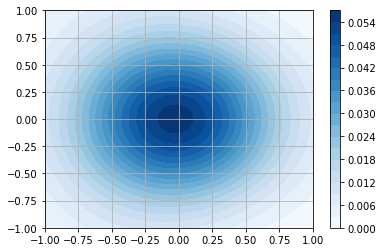

In [68]:
fig1=plt.figure(1)
side = np.linspace(-1,1,100)
kxv, kyv = np.meshgrid(side,side)
Zu = density_func(SIDISmodelsArray[0], [0.1], [2], 0.57, -2, kxv, kyv)
# Plot the density map using nearest-neighbor interpolation
#plt.pcolormesh(kxv,kyv,Zu)
#plt.pcolormesh(kxv,kyv,Zu)
#plt.contourf(kxv,kyv,Zu, 20, cmap='Reds')
plt.contourf(kxv,kyv,Zu, 20, cmap='Blues')
#plt.contourf(kxv,kyv,Zu, 20, cmap='Greens')
plt.grid()
plt.colorbar()
plt.savefig('test_3D_plot_ubar')
print(Zu[0])

In [113]:
def ThreeD_Dat_to_CSV(numreplicas, x, QQ, kperp2avg, kx, ky):
    data_dictionary = {'x':[], 'Q2':[], 'kp2A':[], 'kx':[], 'ky':[], 'ru':[], 'rubar':[], 'rd':[], 'rdbar':[], 'rs':[], 'rsbar':[]}
    results = ThreeD_data_FromReplicas(numreplicas, x, QQ, kperp2avg, kx, ky)
    alength = len(kx)
    temp_x = np.array([i*0+x for i in range(0,alength)])
    temp_QQ = np.array([i*0+QQ for i in range(0,alength)])
    temp_kp2A = np.array([i*0+kperp2avg for i in range(0,alength)])
    temp_kx = kx
    temp_ky = ky
    temp_ru = results[0].mean(axis=0)
    temp_rubar = results[1].mean(axis=0)
    temp_rd = results[2].mean(axis=0)
    temp_rdbar = results[3].mean(axis=0)
    temp_rs = results[4].mean(axis=0)
    temp_rsbar = results[5].mean(axis=0)
    data_dictionary['x'] = temp_x
    data_dictionary['Q2'] = temp_QQ
    data_dictionary['kp2A'] = temp_kp2A
    data_dictionary['kx'] = temp_kx
    data_dictionary['ky'] = temp_ky
    data_dictionary['ru'] = temp_ru
    data_dictionary['rubar'] = temp_rubar
    data_dictionary['rd'] = temp_rd
    data_dictionary['rdbar'] = temp_rdbar
    data_dictionary['rs'] = temp_rs
    data_dictionary['rsbar'] = temp_rsbar
    return pd.DataFrame(data_dictionary)


#DensityCSVData = ThreeD_Dat_to_CSV(numreplicas_SIDIS, 0.1, 2, 0.57, kxv, kyv)
#DensityCSVData.to_csv('3D_density.csv')

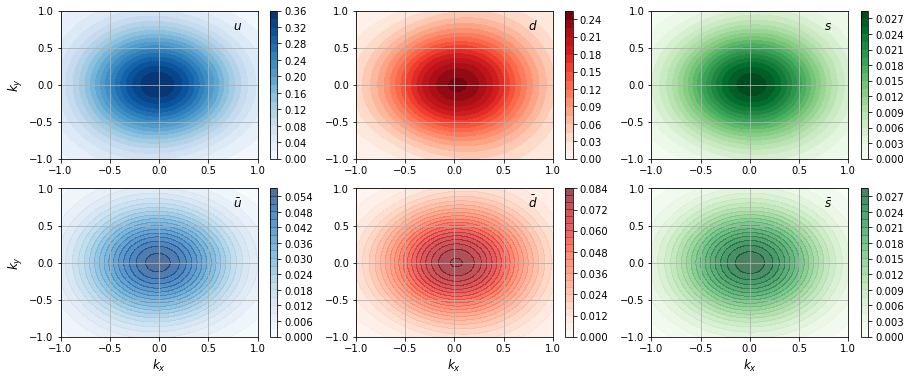

In [112]:
def DensityPlotValues(numreplicas, x, QQ, kperp2avg, kx, ky):
    results = ThreeD_data_FromReplicas(numreplicas, x, QQ, kperp2avg, kx, ky)
    temp_kx = kx
    temp_ky = ky
    temp_ru = results[0].mean(axis=0)
    temp_rubar = results[1].mean(axis=0)
    temp_rd = results[2].mean(axis=0)
    temp_rdbar = results[3].mean(axis=0)
    temp_rs = results[4].mean(axis=0)
    temp_rsbar = results[5].mean(axis=0)
    return np.array(temp_ru),np.array(temp_rubar),np.array(temp_rd),np.array(temp_rdbar),np.array(temp_rs),np.array(temp_rsbar)

Dens_Result_all=DensityPlotValues(numreplicas_SIDIS, 0.1, 2, 0.57, kxv, kyv)

fig1=plt.figure(1,figsize=(15,6))
plt.subplot(2,3,1)
plt.contourf(kxv, kyv,Dens_Result_all[0], 20, cmap='Blues')
plt.ylabel('$k_y$',size='12')
plt.text(0.75,0.75,'$u$',size='12')
plt.grid()
plt.colorbar()
plt.subplot(2,3,2)
plt.contourf(kxv, kyv,Dens_Result_all[2], 20, cmap='Reds')
plt.text(0.75,0.75,'$d$',size='12')
plt.grid()
plt.colorbar()
plt.subplot(2,3,3)
plt.contourf(kxv, kyv,Dens_Result_all[4], 20, cmap='Greens')
plt.text(0.75,0.75,'$s$',size='12')
plt.grid()
plt.colorbar()
plt.subplot(2,3,4)
plt.contourf(kxv, kyv,Dens_Result_all[1], 20, cmap='Blues', alpha=0.7)
plt.xlabel('$k_x$',size='12')
plt.ylabel('$k_y$',size='12')
plt.text(0.75,0.75,'$\\bar{u}$',size='12')
plt.grid()
plt.colorbar()
plt.subplot(2,3,5)
plt.contourf(kxv, kyv,Dens_Result_all[3], 20, cmap='Reds', alpha=0.7)
plt.xlabel('$k_x$',size='12')
plt.text(0.75,0.75,'$\\bar{d}$',size='12')
plt.grid()
plt.colorbar()
plt.subplot(2,3,6)
plt.contourf(kxv, kyv,Dens_Result_all[5], 20, cmap='Greens', alpha=0.7)
plt.xlabel('$k_x$',size='12')
plt.text(0.75,0.75,'$\\bar{s}$',size='12')
plt.grid()
plt.colorbar()
plt.savefig('3D_dist.pdf')
# plt.contourf(kxv,kyv,testZu, 20, cmap='Blues')
# plt.grid()
# plt.colorbar()